# Required Libraries

In [152]:
from typing import Dict, List

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)
from sklearn.metrics import accuracy_score, auc, roc_curve
from sklearn.mixture import BayesianGaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

pd.set_option("display.max_columns", None)
pd.options.display.max_rows = 4000
RANDOM_SEED = 9509


In [153]:
import pymc3 as pm
import bambi

# Pre-defined Functions for modelling

In [154]:
def plot_roc_curve(y_test:np.ndarray, y_pred:np.ndarray, title="ROC Curve"):
    """ Plot ROC curve

    Args:
        y_test (np.ndarray): Test dataset
        y_pred (np.ndarray): Predicted dataset
    """
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10, 5))
    plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:0.3f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

In [155]:
def plot_traces(traces, model, retain=0):
    """
    Convenience function:
    Plot traces with overlaid means and values
    """
    summary = az.summary(traces, stat_funcs={"mean": np.mean}, extend=False)
    ax = az.plot_trace(
        traces,
        lines=tuple([(k, {}, v["mean"]) for k, v in summary.iterrows()]),
    )

    for i, mn in enumerate(summary["mean"].values):
        ax[i, 0].annotate(
            f"{mn:.2f}",
            xy=(mn, 0),
            xycoords="data",
            xytext=(5, 10),
            textcoords="offset points",
            rotation=90,
            va="bottom",
            fontsize="large",
            color="C0",
        )

In [156]:
def set_priors(
    intercept_prior: bambi.Prior, regressor_prior: bambi.Prior, regressors: List[str]
) -> Dict[str, bambi.Prior]:
    """Construct Prior specification of parameters

    Args:
        intercept_prior (bambi.Prior): Prior distribution of intercept
        regressor_prior (bambi.Prior): Prior distribution of regressors
        regressors (List[str]): A list of regressors

    Returns:
        Dict[str, bambi.Prior]: A dictionary of priors
    """
    reg_prior = {i: regressor_prior for i in regressors}
    int_prior = {"Intercept": intercept_prior}
    return {**int_prior, **reg_prior}


# Data


In [157]:
# Data Source: https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers
df = pd.read_csv("data/BankChurners.csv")


In [254]:
print(df.shape)


(10127, 19)


## Data Exploration


Explore the top 5 rows of imported Bank churn rate dataset

In [159]:
df.head()


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


Dropping irrelevant variables

In [160]:
# Drop variables that are not required
df.drop(
    [
        "CLIENTNUM",
        "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1",
        "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2",
        "Card_Category",
    ],
    axis=1,
    inplace=True,
)


Check the data sparsity (Null) and data type of features

In [161]:
# Non-null data, balanced data
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Months_on_book            10127 non-null  int64  
 8   Total_Relationship_Count  10127 non-null  int64  
 9   Months_Inactive_12_mon    10127 non-null  int64  
 10  Contacts_Count_12_mon     10127 non-null  int64  
 11  Credit_Limit              10127 non-null  float64
 12  Total_Revolving_Bal       10127 non-null  int64  
 13  Avg_Open_To_Buy           10127 non-null  float64
 14  Total_

In [162]:
df.describe(include="all")

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,10127,10127.000000,10127,10127.000000,10127,10127,10127,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
unique,2,NaN,2,NaN,7,4,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Existing Customer,NaN,F,NaN,Graduate,Married,Less than $40K,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,8500,NaN,5358,NaN,3128,4687,3561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,46.325960,NaN,2.346203,NaN,NaN,NaN,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,NaN,8.016814,NaN,1.298908,NaN,NaN,NaN,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,NaN,26.000000,NaN,0.000000,NaN,NaN,NaN,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,NaN,41.000000,NaN,1.000000,NaN,NaN,NaN,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,NaN,46.000000,NaN,2.000000,NaN,NaN,NaN,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,NaN,52.000000,NaN,3.000000,NaN,NaN,NaN,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000


Based on the Attrition flag composition below, it can be concluded that the number of attrited customers are significantly lower and the modelling process should be careful not to blindly classifying all the individuals as existing customers.

In [163]:
df.Attrition_Flag.value_counts(normalize=True)

Existing Customer    0.83934
Attrited Customer    0.16066
Name: Attrition_Flag, dtype: float64

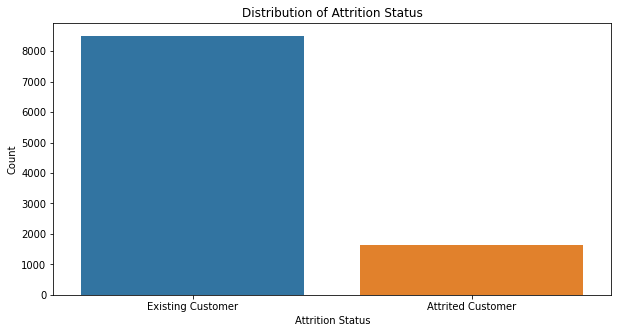

In [164]:
# Target Variable
m = df["Attrition_Flag"].value_counts()
m = m.to_frame()
m.reset_index(inplace=True)
m.columns = ["Attrition Status", "Count"]
plt.subplots(figsize=(10, 5))
sns.barplot(y="Count", x="Attrition Status", data=m)
plt.xlabel("Attrition Status")
plt.ylabel("Count")
plt.title("Distribution of Attrition Status")
plt.show()


## Data Pre-processing


### Convert target variable to binary variable


In [165]:
# Convert Categorical Variables to Numerical (1 == Bad credit)
def attrition_status(status):
    if status == "Existing Customer":
        return 0
    else:
        return 1


df["Attrition_Flag"] = df["Attrition_Flag"].apply(attrition_status)
df["Attrition_Flag"].value_counts()


0    8500
1    1627
Name: Attrition_Flag, dtype: int64

### Encoding of categorical variables (OneHotEncoding / LabelEncoding)

As there are categorical values within the dataset, encoding of categorical variables is required. For non-hierarchial variables, dummification is required (e.g, Marital status, Gender and Card category), whereas Label encoding is recommended for variables with rank ordering relationship (e.g., Income level and Education level)


In [166]:
# Separating categorical and non-categorical features
cat_features = [
    col for col in df.columns if (df[col].dtype == "object") & (col != "Attrition_Flag")
]
num_features = [
    col for col in df.columns if (df[col].dtype != "object") & (col != "Attrition_Flag")
]


In [167]:
# Prepare dataframes
df_y = df["Attrition_Flag"]
df_x = df.loc[:, num_features].astype("float32")


#### OneHot Encoding


In [168]:
# Features with hierarchial structure, label encoding suits better
le_features = ["Income_Category", "Education_Level"]

# Features with non-hierarchial structure, dummification (OneHotEncoding) suits better
oe_features = [i for i in cat_features if i not in le_features]

print(f"OneHot Encoding Features: {oe_features}")
print(f"Label Encoding Features: {le_features}")

onehot_encoders = {}
for col in oe_features:
    oe = OneHotEncoder(handle_unknown="ignore", drop="first")
    onehot_encoders[col] = oe
    df_onehot = pd.DataFrame(oe.fit_transform(df[[col]]).toarray())
    df_onehot.columns = oe.get_feature_names_out()
    df_x = pd.concat([df_x, df_onehot], axis=1)


OneHot Encoding Features: ['Gender', 'Marital_Status']
Label Encoding Features: ['Income_Category', 'Education_Level']


#### Label Encoding


In [169]:
def education_encoder(status):
    if status == "Unknown":
        return 0
    elif status == "Uneducated":
        return 1
    elif status == "High School":
        return 2
    elif status == "College":
        return 3
    elif status == "Graduate":
        return 4
    elif status == "Post-Graduate":
        return 5
    elif status == "Doctorate":
        return 6


def income_category(status):
    if status == "Unknown":
        return 0
    elif status == "Less than $40K":
        return 1
    elif status == "$40K - $60K":
        return 2
    elif status == "$60K - $80K":
        return 3
    elif status == "$80K - $120K":
        return 4
    elif status == "$120K +":
        return 5


In [170]:
df_x["Income_Category"] = df["Income_Category"].apply(income_category)
df_x["Education_Level"] = df["Education_Level"].apply(education_encoder)


#### Data Standardisation


For faster convergence and zero-centering, standardisation of dataset is applied

In [171]:
# Copying non-standardised dataset for clustering
df_x_raw = df_x.copy()
df_y_raw = df_y.copy()

scaler = StandardScaler()
scaler.fit(df_x)
df_x[:] = scaler.transform(df_x)


In [172]:
df_x.head()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_M,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown,Income_Category,Education_Level
0,-0.165406,0.503368,0.384621,0.763943,-1.327136,0.492404,0.446622,-0.473422,0.488971,2.623495,-0.959707,-0.973895,3.834003,-0.775882,1.059956,1.077338,-0.798507,-0.282609,0.620039,-0.354022
1,0.333570,2.043199,1.010715,1.407306,-1.327136,-0.411616,-0.041367,-0.366667,-0.008486,3.563293,-0.916433,-1.357340,12.608573,-0.616276,-0.943436,-0.928214,1.252337,-0.282609,-0.736292,0.822218
2,0.583058,0.503368,0.008965,0.120579,-1.327136,-2.219655,-0.573698,-1.426858,-0.445658,8.367214,-0.740982,-1.911206,6.807863,-0.997155,1.059956,1.077338,-0.798507,-0.282609,1.298204,0.822218
3,-0.789126,1.273283,-0.241473,-0.522785,1.641478,-1.315636,-0.585251,1.661686,-0.734100,2.942843,-0.951758,-1.911206,6.807863,1.759686,-0.943436,-0.928214,-0.798507,3.538459,-0.736292,-0.354022
4,-0.789126,0.503368,-1.869317,0.763943,-1.327136,-2.219655,-0.430877,-1.426858,-0.302868,6.455682,-1.056263,-1.570365,7.509325,-0.997155,1.059956,1.077338,-0.798507,-0.282609,0.620039,-0.942142


In [173]:
df_x.describe()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_M,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown,Income_Category,Education_Level
count,1.012700e+04,1.012700e+04,1.012700e+04,1.012700e+04,1.012700e+04,1.012700e+04,1.012700e+04,1.012700e+04,1.012700e+04,1.012700e+04,1.012700e+04,1.012700e+04,1.012700e+04,1.012700e+04,1.012700e+04,1.012700e+04,1.012700e+04,1.012700e+04,1.012700e+04,1.012700e+04
mean,1.333101e-16,-7.577626e-17,-3.381866e-16,-4.490445e-17,1.613754e-16,-7.858279e-17,-4.490445e-17,-7.016320e-17,3.367834e-17,-1.206807e-16,-8.980890e-17,-2.245222e-16,-5.753382e-17,8.980890e-17,6.735667e-17,2.666202e-17,-8.419584e-18,-7.156646e-17,-1.066481e-16,7.016320e-17
std,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00
min,-2.535541e+00,-1.806378e+00,-2.871068e+00,-1.809512e+00,-2.316674e+00,-2.219655e+00,-7.915266e-01,-1.426858e+00,-8.213361e-01,-3.466947e+00,-1.146344e+00,-2.337256e+00,-2.991597e+00,-9.971550e-01,-9.434357e-01,-9.282138e-01,-7.985069e-01,-2.826089e-01,-1.414457e+00,-1.530263e+00
25%,-6.643815e-01,-1.036462e+00,-6.171294e-01,-5.227845e-01,-3.375979e-01,-4.116160e-01,-6.686548e-01,-9.863389e-01,-6.759604e-01,-5.882439e-01,-6.619405e-01,-8.460801e-01,-5.469819e-01,-9.137243e-01,-9.434357e-01,-9.282138e-01,-7.985069e-01,-2.826089e-01,-7.362920e-01,-9.421423e-01
50%,-4.066159e-02,-2.665471e-01,8.964513e-03,1.205790e-01,-3.375979e-01,-4.116160e-01,-4.492525e-01,1.388875e-01,-4.394979e-01,-1.092203e-01,-1.486877e-01,9.123036e-02,-4.293766e-02,-3.587287e-01,-9.434357e-01,-9.282138e-01,-7.985069e-01,-2.826089e-01,-5.812655e-02,2.340982e-01
75%,7.078024e-01,5.033681e-01,5.098397e-01,7.639426e-01,6.519402e-01,4.924038e-01,2.679862e-01,7.622408e-01,2.629041e-01,4.519216e-01,9.918090e-02,6.877007e-01,4.443051e-01,8.274385e-01,1.059956e+00,1.077338e+00,1.252337e+00,-2.826089e-01,6.200389e-01,8.222185e-01
max,3.327426e+00,2.043199e+00,2.513340e+00,1.407306e+00,3.620555e+00,3.204463e+00,2.848054e+00,1.661686e+00,2.975375e+00,1.203060e+01,4.144855e+00,3.158792e+00,1.260857e+01,2.626640e+00,1.059956e+00,1.077338e+00,1.252337e+00,3.538459e+00,1.976370e+00,1.998459e+00


According to the correlation matrix below, the multicollinearity is not a significant issue in this dataset

<AxesSubplot:>

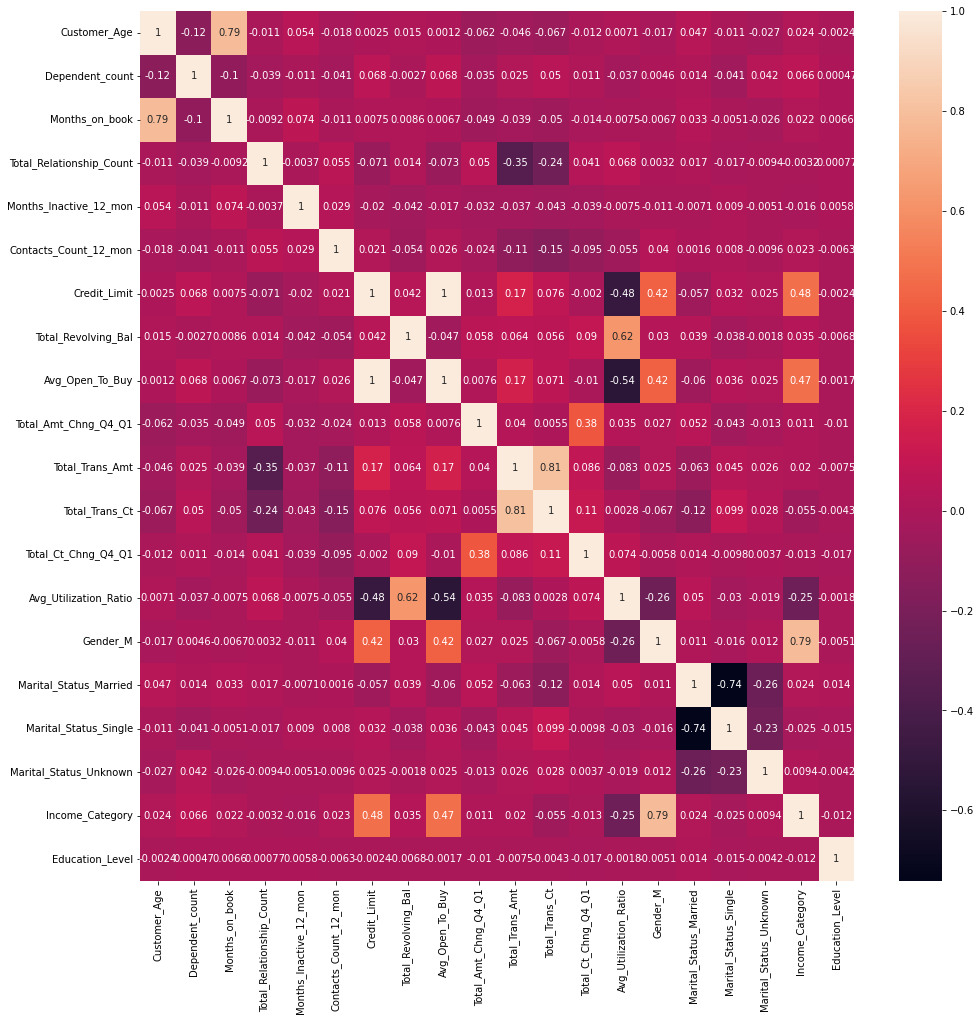

In [255]:
plt.figure(figsize=(16,16))
sns.heatmap(df_x.corr(), annot=True)

### Split train / test dataset


To prevent the model overfitting, the train-test is split by 8:2 

In [174]:
x_train, x_test, y_train, y_test = train_test_split(
    df_x, df_y, test_size=0.2, random_state=RANDOM_SEED
)


In [176]:
train_data = pd.concat([x_train, y_train], axis=1)


In [177]:
train_data.head()


,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_M,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown,Income_Category,Education_Level,Attrition_Flag
4883,-0.664382,-0.266547,-0.867567,1.407306,0.651940,1.396424,2.177523,0.116800,2.166595,-0.401197,0.128619,0.645096,-0.471375,-0.837548,1.059956,-0.928214,1.252337,-0.282609,1.298204,-0.354022,0
5202,0.957290,-0.266547,0.885496,1.407306,0.651940,-0.411616,-0.314464,0.437066,-0.353582,-1.377492,0.011750,0.219045,-0.189951,-0.043143,1.059956,1.077338,-0.798507,-0.282609,1.298204,-1.530263,0
5066,-0.290150,1.273283,-0.491911,1.407306,0.651940,1.396424,-0.791527,-1.218256,-0.682143,0.588785,-0.552578,-0.846080,-1.286247,-0.569119,-0.943436,-0.928214,1.252337,-0.282609,-0.736292,-0.942142,1
8366,0.333570,1.273283,-0.742348,-1.809512,0.651940,0.492404,-0.676357,0.595359,-0.729589,-0.752480,-0.057724,0.261650,0.868542,1.407826,-0.943436,-0.928214,-0.798507,-0.282609,-0.058127,0.822218,0
5012,-0.290150,-0.266547,0.134183,-0.522785,-1.327136,0.492404,-0.733573,-0.174016,-0.717818,-1.112889,-0.128375,-0.334820,0.288891,0.889105,1.059956,-0.928214,-0.798507,3.538459,1.298204,0.822218,0


# Model Methodology


## Logistic Regression


In [178]:
# Define the full model equation (Including all features)
regressors = x_train.columns
formula = f"Attrition_Flag ~ " + " + ".join(regressors)
print(formula)

Attrition_Flag ~ Customer_Age + Dependent_count + Months_on_book + Total_Relationship_Count + Months_Inactive_12_mon + Contacts_Count_12_mon + Credit_Limit + Total_Revolving_Bal + Avg_Open_To_Buy + Total_Amt_Chng_Q4_Q1 + Total_Trans_Amt + Total_Trans_Ct + Total_Ct_Chng_Q4_Q1 + Avg_Utilization_Ratio + Gender_M + Marital_Status_Married + Marital_Status_Single + Marital_Status_Unknown + Income_Category + Education_Level


In [256]:
# Specifying the prior distributions in advance that are used in the next steps
normal_prior = bambi.Prior("Normal", mu=0, sigma=10)
laplace_prior = bambi.Prior("Laplace", mu=0, b=0.05)
t_prior = bambi.Prior("StudentT", nu=7, mu=0, sigma=2.5)

### Bayesian Lasso

$\beta$ that minimize the $\ell_1$ norm also maximize the probability of random variables iid from the Laplace distribution, $Laplace(\beta_k | 0, 1 / \lambda)$

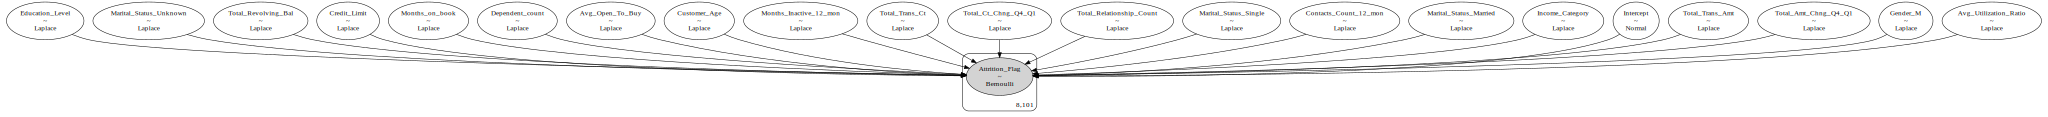

In [180]:
laplace_logit = bambi.Model(
    formula,
    train_data,
    priors=set_priors(normal_prior, laplace_prior, regressors),
    family="bernoulli",
)
laplace_logit.build()
laplace_logit.graph()


In [181]:
# Fitting the model
laplace_logit_result = laplace_logit.fit(init="adapt_diag", random_seed=RANDOM_SEED)

Modeling the probability that Attrition_Flag==1
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Education_Level, Income_Category, Marital_Status_Unknown, Marital_Status_Single, Marital_Status_Married, Gender_M, Avg_Utilization_Ratio, Total_Ct_Chng_Q4_Q1, Total_Trans_Ct, Total_Trans_Amt, Total_Amt_Chng_Q4_Q1, Avg_Open_To_Buy, Total_Revolving_Bal, Credit_Limit, Contacts_Count_12_mon, Months_Inactive_12_mon, Total_Relationship_Count, Months_on_book, Dependent_count, Customer_Age, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.


In [183]:
# Summary statistics of model fitting
az.summary(laplace_logit_result)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-2.832,0.062,-2.941,-2.712,0.001,0.001,2549.0,2828.0,1.0
Customer_Age,-0.012,0.035,-0.085,0.049,0.001,0.001,3550.0,2601.0,1.0
Dependent_count,0.150,0.042,0.074,0.229,0.001,0.000,3696.0,2568.0,1.0
Months_on_book,-0.007,0.035,-0.076,0.059,0.001,0.001,3678.0,2545.0,1.0
Total_Relationship_Count,-0.658,0.046,-0.746,-0.576,0.001,0.001,3925.0,2851.0,1.0
Months_Inactive_12_mon,0.467,0.041,0.388,0.545,0.001,0.000,3817.0,2695.0,1.0
Contacts_Count_12_mon,0.511,0.042,0.437,0.595,0.001,0.000,3977.0,2945.0,1.0
Credit_Limit,0.002,0.045,-0.084,0.088,0.001,0.001,3248.0,2548.0,1.0
Total_Revolving_Bal,-0.695,0.053,-0.786,-0.590,0.001,0.001,2740.0,2573.0,1.0
Avg_Open_To_Buy,0.008,0.044,-0.083,0.090,0.001,0.001,3504.0,2454.0,1.0


In [184]:
# Feature importance by magnitude of coefficients
feature_importance = az.summary(laplace_logit_result)[["mean"]]
feature_imp = (abs(feature_importance) / abs(feature_importance.sum())).sort_values(
    by="mean", ascending=False
)
print(f"Top 7 features excluding intercept: {feature_imp.head(7)}")
shrinked_features = feature_imp.index[1:8]


Top 7 features excluding intercept:                               mean
Intercept                 0.530436
Total_Trans_Ct            0.460573
Total_Trans_Amt           0.257726
Total_Revolving_Bal       0.130174
Total_Ct_Chng_Q4_Q1       0.128301
Total_Relationship_Count  0.123244
Contacts_Count_12_mon     0.095711


In [185]:
# Update the model equation after regularization
updated_formula = f"Attrition_Flag ~ " + " + ".join(shrinked_features)
print(updated_formula)

Attrition_Flag ~ Total_Trans_Ct + Total_Trans_Amt + Total_Revolving_Bal + Total_Ct_Chng_Q4_Q1 + Total_Relationship_Count + Contacts_Count_12_mon + Months_Inactive_12_mon


<AxesSubplot:xlabel='Attrition_Flag / Attrition_Flag'>

/Users/joonkang/.pyenv/versions/3.9.11/envs/st451_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


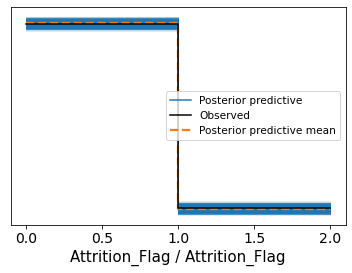

In [186]:
posterior_predictive_laplace = laplace_logit.predict(
    laplace_logit_result, kind="pps", data=x_test
)
az.plot_ppc(laplace_logit_result)

accuracy =  0.898


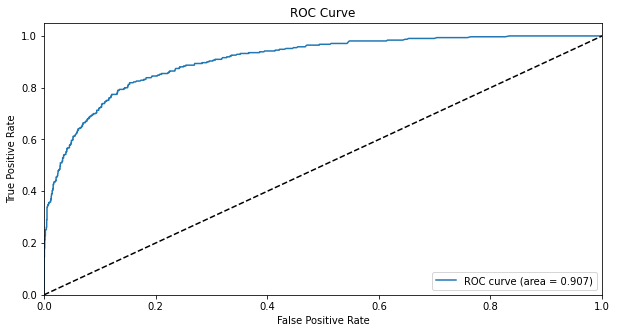

In [187]:
# Compute the point prediction by taking the mean
# and defining the category via a threshold.
y_pred = (
    laplace_logit_result["posterior_predictive"]["Attrition_Flag"]
    .values.mean(axis=0)
    .mean(axis=0)
)
y_test_pred = (y_pred >= 0.5).astype("int")

print(f"accuracy = {accuracy_score(y_true=y_test, y_pred=y_test_pred): 0.3f}")

# Plot ROC-AUC curve to inspect the model performance
plot_roc_curve(y_test, y_pred)

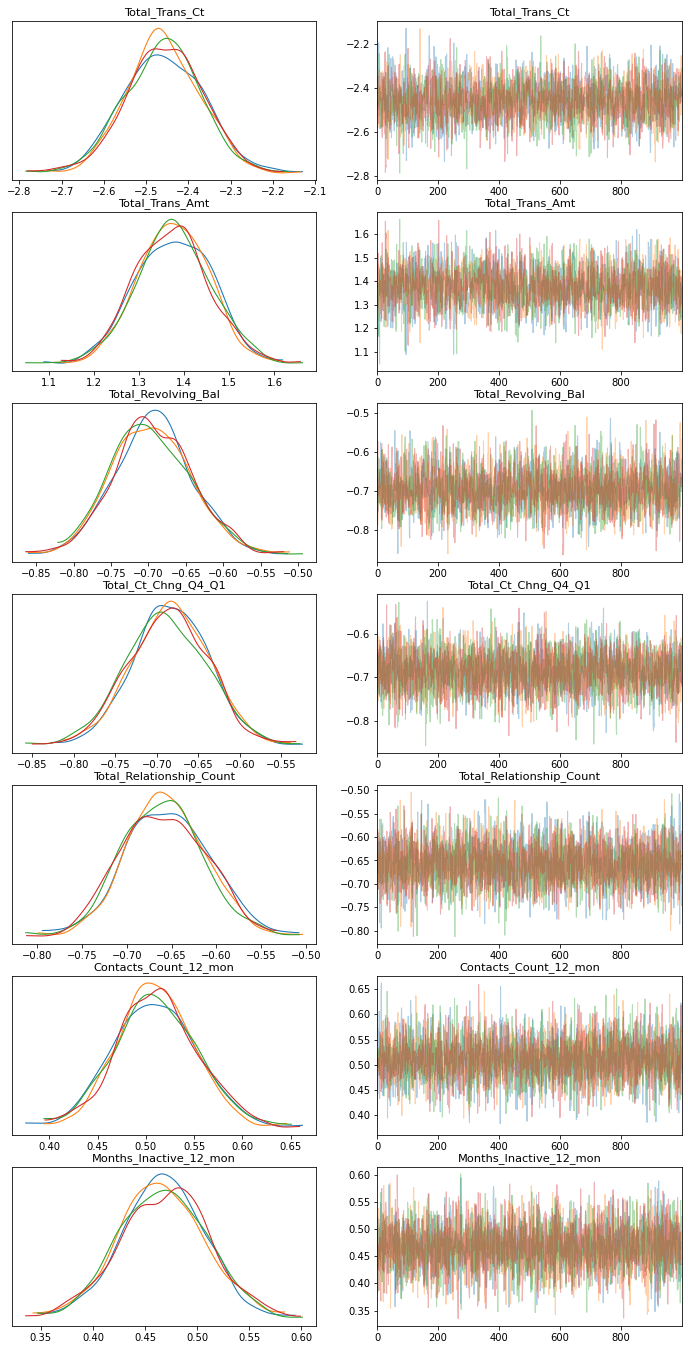

In [188]:
# Plot posterior distributions
az.plot_trace(laplace_logit_result, var_names=feature_imp.index[1:8] ,compact=False, figsize=(12,24),divergences='top');

### Student-t prior


Suppose we believe — prior to seeing the data — that α, 𝛽1, and 𝛽2 are probably close to zero, are as likely to be positive as they are to be negative, but have a small chance of being quite far from zero. These beliefs can be represented by Student t distributions with a few degrees of freedom in order to produce moderately heavy tails.


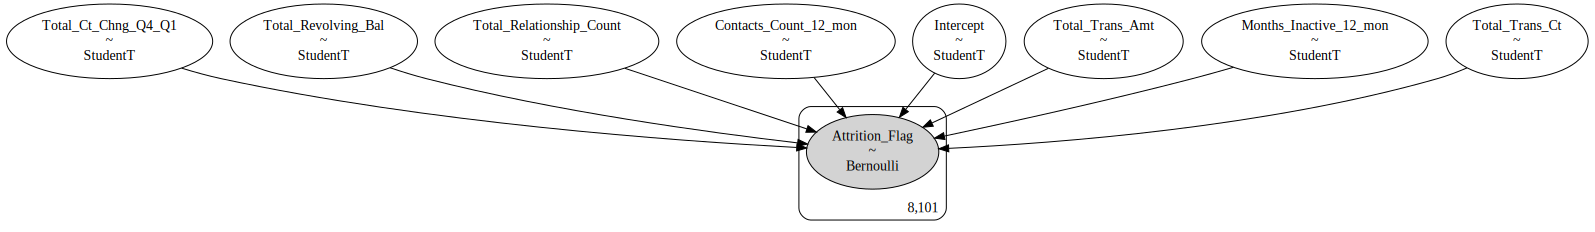

In [244]:
t_logit = bambi.Model(
    updated_formula,
    train_data,
    priors=set_priors(t_prior, t_prior, regressors),
    family="bernoulli",
)
t_logit.build()
t_logit.graph()

In [247]:
t_logit_result = t_logit.fit(init="adapt_diag", random_seed=RANDOM_SEED)

Modeling the probability that Attrition_Flag==1
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Months_Inactive_12_mon, Contacts_Count_12_mon, Total_Relationship_Count, Total_Ct_Chng_Q4_Q1, Total_Revolving_Bal, Total_Trans_Amt, Total_Trans_Ct, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.


In [250]:
az.summary(t_logit_result)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-2.970,0.069,-3.099,-2.844,0.001,0.001,2277.0,2778.0,1.0
Total_Trans_Ct,-2.597,0.096,-2.765,-2.411,0.002,0.001,2107.0,2345.0,1.0
Total_Trans_Amt,1.538,0.084,1.376,1.692,0.002,0.001,2475.0,2646.0,1.0
Total_Revolving_Bal,-0.813,0.042,-0.890,-0.734,0.001,0.000,4521.0,2837.0,1.0
Total_Ct_Chng_Q4_Q1,-0.761,0.048,-0.850,-0.667,0.001,0.000,5003.0,2917.0,1.0
Total_Relationship_Count,-0.724,0.049,-0.813,-0.629,0.001,0.001,4339.0,2611.0,1.0
Contacts_Count_12_mon,0.543,0.045,0.464,0.631,0.001,0.000,4565.0,2922.0,1.0
Months_Inactive_12_mon,0.521,0.042,0.439,0.598,0.001,0.000,4958.0,3244.0,1.0


<AxesSubplot:xlabel='Attrition_Flag / Attrition_Flag'>

/Users/joonkang/.pyenv/versions/3.9.11/envs/st451_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


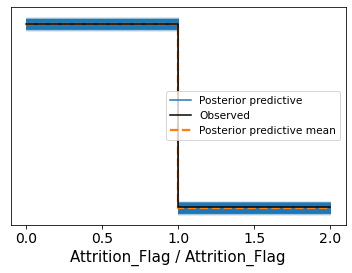

In [192]:
posterior_predictive_t = t_logit.predict(t_logit_result, kind="pps", data=x_test)
az.plot_ppc(t_logit_result)

accuracy =  0.896


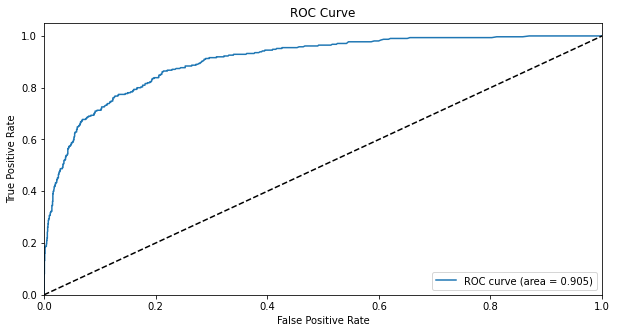

In [194]:
# Compute the point prediction by taking the mean
# and defining the category via a threshold.
y_pred = (
    t_logit_result["posterior_predictive"]["Attrition_Flag"]
    .values.mean(axis=0)
    .mean(axis=0)
)
y_test_pred = (y_pred >= 0.5).astype("int")

print(f"accuracy = {accuracy_score(y_true=y_test, y_pred=y_test_pred): 0.3f}")
plot_roc_curve(y_test, y_pred)

In [195]:
# Feature importance by magnitude of coefficients
feature_importance = az.summary(t_logit_result)[["mean"]]
feature_imp = (abs(feature_importance) / abs(feature_importance.sum())).sort_values(
    by="mean", ascending=False
)
print(f"Top 7 features excluding intercept: {feature_imp.head(7)}")
shrinked_features = feature_imp.index[1:8]


Top 7 features excluding intercept:                               mean
Intercept                 0.564854
Total_Trans_Ct            0.493914
Total_Trans_Amt           0.292887
Total_Revolving_Bal       0.154241
Total_Ct_Chng_Q4_Q1       0.144732
Total_Relationship_Count  0.137695
Contacts_Count_12_mon     0.103461


## LDA


In [203]:
# The formulas used are the following equations in Bishop
# Prior probability of class 0 : 4.73
# Mean of features 4.75, 4.76
# Covariance matrix 4.78
clf = LinearDiscriminantAnalysis(solver="lsqr", store_covariance=True)
clf.fit(x_train, y_train)


LinearDiscriminantAnalysis(solver='lsqr', store_covariance=True)

Accuracy Score 0.8973346495557749


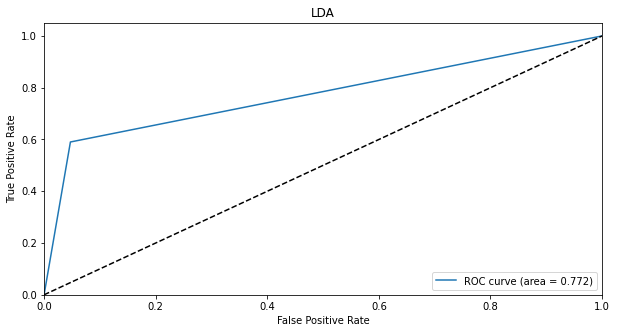

In [204]:
pred_lda = clf.predict(x_test)
print(f"Accuracy Score {accuracy_score(y_true=y_test, y_pred=pred_lda)}")
plot_roc_curve(y_test, pred_lda, "LDA")


# QDA


Accuracy Score 0.903751233958539


/Users/joonkang/.pyenv/versions/3.9.11/envs/st451_env/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


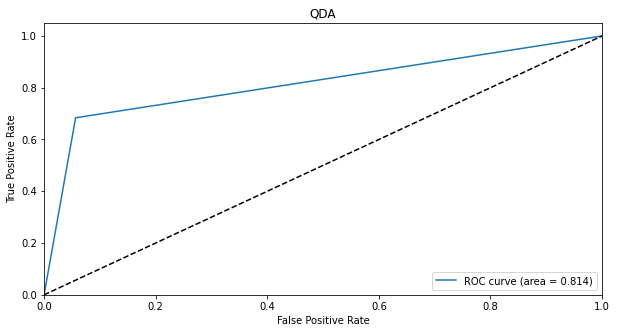

In [205]:
clf = QuadraticDiscriminantAnalysis()
clf.fit(x_train, y_train)

pred_qda = clf.predict(x_test)
print(f"Accuracy Score {accuracy_score(y_true=y_test, y_pred=pred_qda)}")
plot_roc_curve(y_test, pred_qda, title="QDA")

# Cluster Analysis

On top of the data pre-processing in earlier steps, the dimension reduction via PCA is required for better visualisation of clustering analysis

In [219]:
pca = PCA(n_components = 2) 
x_principal = pca.fit_transform(df_x) 
x_principal = pd.DataFrame(x_principal) 
x_principal.columns = ['P1', 'P2']
x_principal.head(5)

,P1,P2
0,1.081680,-1.404177
1,-0.763164,0.966875
2,0.434405,-0.736335
3,-2.323802,0.881575
4,0.263267,-0.063688


To showcase the power of Bayesian Gaussian Mixture, the number of cluster is set to 10, bigger than necessary and the weight concentration prior is set close to zero

In [224]:
n_cluster = 10
bgmm = BayesianGaussianMixture(
    n_components=n_cluster,
    covariance_type="full",
    weight_concentration_prior=10**-5,
    random_state=RANDOM_SEED,
    max_iter=10000,
)
bgmm.fit(x_principal)
bgmm


BayesianGaussianMixture(max_iter=10000, n_components=10, random_state=9509,
                        weight_concentration_prior=1e-05)

According to the clustering result below, the effective number of clusters is 9 instead of 10

In [225]:
probs = bgmm.predict_proba(x_principal)
results = np.sum(probs, axis=0)
results = pd.DataFrame(
    results.round(0), columns=["# of individuals"], index=range(1, n_cluster + 1)
)
results


,# of individuals
1,1541.0
2,0.0
3,807.0
4,354.0
5,2268.0
6,410.0
7,393.0
8,1482.0
9,604.0
10,2268.0


Text(0, 0.5, 'P2')

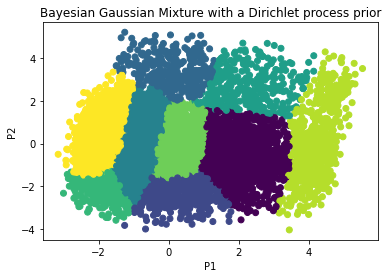

In [227]:
y_pred  = bgmm.predict(x_principal)
plt.scatter(x_principal["P1"], x_principal["P2"], c=y_pred, cmap="viridis")
plt.title("Bayesian Gaussian Mixture with a Dirichlet process prior")
plt.xlabel("P1")
plt.ylabel("P2")

Furthermore, it is possible to inspect the characteristics of each cluster by aggregating the raw data by labelled clusters

In [228]:
df_label = df.copy()
df_label["Cluster"] = y_pred

In [243]:
df_label.groupby(["Cluster"]).mean()[[*shrinked_features, "Attrition_Flag"]].sort_values("Attrition_Flag")

,Total_Trans_Ct,Total_Trans_Amt,Total_Revolving_Bal,Total_Ct_Chng_Q4_Q1,Total_Relationship_Count,Contacts_Count_12_mon,Months_Inactive_12_mon,Attrition_Flag
Cluster,,,,,,,,
3,108.872576,13942.044321,1423.529086,0.752017,2.174515,2.213296,2.144044,0.019391
5,104.605187,12969.345821,1279.299712,0.735646,2.193084,2.129683,2.152738,0.048991
9,68.403705,4018.321413,1624.331323,0.754074,3.908229,2.290823,2.355019,0.090478
7,63.834146,3818.448780,1012.422300,0.719906,3.939373,2.459930,2.319861,0.149129
0,60.763623,3648.421090,994.220807,0.715083,3.934183,2.542817,2.341826,0.174805
8,70.857143,5912.082707,1150.592481,0.696728,3.369925,2.545865,2.327820,0.177444
6,34.418182,1555.366667,1522.793939,0.616258,4.669697,2.742424,2.439394,0.190909
4,62.196368,3643.089292,867.742338,0.699247,3.898222,2.473704,2.356792,0.214151
2,36.166667,1686.328431,1028.047386,0.616745,4.405229,2.861111,2.454248,0.302288
